## Project Overview


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Library
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from IPython.display import FileLink
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

import glob
import pandas as pd
import pickle
import seaborn as sns
from scipy.signal import savgol_filter

sns.set_style("ticks")


## Dataset Organization, Balancing, and Exploration

In [ ]:
def read_in_data(malignant_glob_path, benign_glob_path):
    # Load data into DataFrames
    df_all = pd.concat([
        pd.DataFrame(glob.glob(malignant_glob_path), columns=['path']),
        pd.DataFrame(glob.glob(benign_glob_path), columns=['path'])
    ], ignore_index=True)

    # Define constants
    zoom_levels = ['40X', '100X', '200X', '400X']

    cancer_subtypes = [
    'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma',
    'adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'
    ]


    label_map = {
        'ductal_carcinoma'    : 0, 'lobular_carcinoma'    : 1, 'mucinous_carcinoma'  : 2,
        'papillary_carcinoma' : 3, 'adenosis'             : 4, 'fibroadenoma'        : 5,
        'phyllodes_tumor'     : 6, 'tubular_adenoma'      : 7
    }

    # Function to extract information from path
    def extract_info(path):
        zoom = next((z for z in zoom_levels if z in path), None)
        subtype = next((s for s in cancer_subtypes if s in path), None)
        return pd.Series([zoom, subtype], index=['zoom_level', 'subtype'])

    # Apply the extraction
    df_all[['zoom_level', 'subtype']] = df_all['path'].apply(extract_info)

    # Reshape the dataframe to have subtypes as columns (Pivot Table)
    df_pivot = df_all.pivot_table(index='zoom_level', columns='subtype', values='path', aggfunc=list)

    # Prepare outputs
    data = df_pivot.T.to_dict()
    all_images = df_all['path'].to_list()
    # Map subtypes to labels directly to ensure correspondence with all_images
    all_labels = df_all['subtype'].map(label_map).fillna(-1).astype(int).to_list()

    return data, all_images, all_labels, label_map

# Define paths
malignant_path = './drive/MyDrive/umich_courses/1_fall_2025/1_term_project/data/BreaKHis_v1/histology_slides/breast/malignant/SOB/*/*/*/*'
benign_path = './drive/MyDrive/umich_courses/1_fall_2025/1_term_project/data/BreaKHis_v1/histology_slides/breast/benign/SOB/*/*/*/*'

# Execute function
data, all_images, all_labels, label_map = read_in_data(malignant_path, benign_path)

In [ ]:
# Compute frequency of each class (tumor)
def tumor_class_freq_calculator(labels):
    return pd.Series(labels).value_counts().sort_index().to_dict()

# plot class distributions across zoom levels
def plot_class_freq(data, legend):
    """
    Plots the distribution of classes across zoom levels

    Args:
        data (dict): Dataset organized by zoom level and class.
    """
    df = pd.DataFrame(data).reindex(['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma',
    'adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'])
    # Calculate the number of images in each list (element-wise)
    df_counts = df.map(len)

    # Convert df_counts from wide to long format
    df_long = df_counts.reset_index().rename(columns={'index': 'subtype'})
    display(df_long)
    df_long = df_long.melt(id_vars='subtype', var_name='zoom_level', value_name='count')
    g = sns.catplot(
        data=df_long, y='subtype', x='count',hue='zoom_level', kind="bar",
        palette="Reds_r", edgecolor=".6", orient="h", order=['ductal_carcinoma',
                                                             'lobular_carcinoma',
                                                             'mucinous_carcinoma',
                                                             'papillary_carcinoma',
                                                             'adenosis',
                                                             'fibroadenoma',
                                                             'phyllodes_tumor',
                                                             'tubular_adenoma'
                                                             ], legend=legend
    )

    g.set_axis_labels("Count of Images", "Class (Tumor)")
    g.set_xticklabels(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


subtype  100X  200X  400X  40X
0     ductal_carcinoma   903   896   788  864
1    lobular_carcinoma   170   163   137  156
2   mucinous_carcinoma   222   196   169  205
3  papillary_carcinoma   142   135   138  145
4             adenosis   113   111   106  114
5         fibroadenoma   260   264   237  253
6      phyllodes_tumor   121   108   115  109
7      tubular_adenoma   150   140   130  149

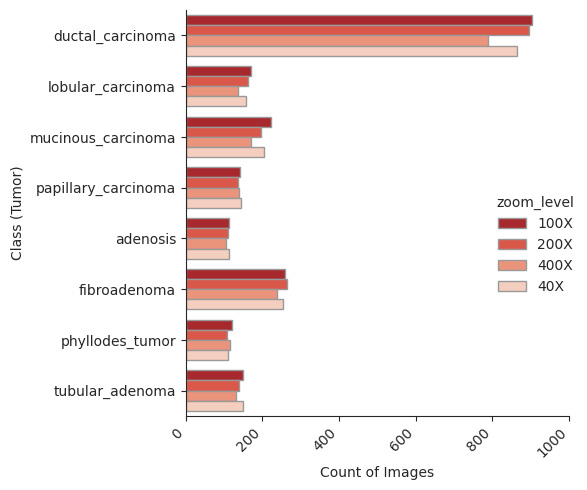

In [ ]:
original_distribution = tumor_class_freq_calculator(all_labels)
plot_class_freq(data, legend=True)

In [ ]:
# Balancing dataset by oversampling/undersampling
def balance_dataset(image_paths, labels):

    df = pd.DataFrame({'path': image_paths, 'label': labels})

    # Calculate the target count (mean of samples per class)
    target_count = int(df['label'].value_counts().mean())

    sampled_indices = []

    # Iterate through each group to collect sampled indices
    for label, group in df.groupby('label'):
        n = len(group)
        if n < target_count:
            # Oversample: sample with replacement
            sampled_indices.extend(group.sample(target_count, replace=True).index)
        else:
            # Undersample: sample without replacement
            sampled_indices.extend(group.sample(target_count, replace=False).index)

    # Create the balanced DataFrame using the collected indices
    balanced_df = df.loc[sampled_indices]

    # Shuffle the resulting dataset to mix classes
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df['path'].tolist(), balanced_df['label'].tolist()

balanced_image_paths, balanced_labels = balance_dataset(all_images, all_labels)


Counts per Class and Zoom Level:


zoom_level           40X  100X  200X  400X  total_images
class_name                                              
ductal_carcinoma     233   260   249   246           988
lobular_carcinoma    270   232   258   228           988
mucinous_carcinoma   255   280   250   203           988
papillary_carcinoma  233   260   242   253           988
adenosis             254   257   248   229           988
fibroadenoma         246   251   257   234           988
phyllodes_tumor      272   254   217   245           988
tubular_adenoma      268   270   229   221           988

Text(0, 0.5, 'Class (Tumor)')

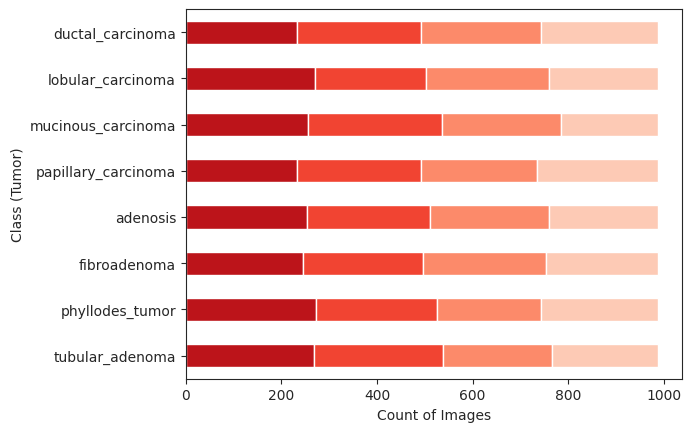

In [ ]:
# Prepare balanced data for plotting
df_balanced = pd.DataFrame({'path': balanced_image_paths, 'label': balanced_labels})

# Map numeric labels to class names
inv_label_map = {v: k for k, v in label_map.items()}
df_balanced['class_name'] = df_balanced['label'].map(inv_label_map)

# Extract zoom level from path
zoom_levels = ['40X', '100X', '200X', '400X']
df_balanced['zoom_level'] = df_balanced['path'].apply(lambda x: next((z for z in zoom_levels if z in x), 'Unknown'))

balanced_data = {
    'balanced': df_balanced.groupby('class_name')['path'].apply(list).to_dict()
}

print("\nCounts per Class and Zoom Level:")
df_sum = df_balanced.groupby(['class_name', 'zoom_level']).size().unstack(fill_value=0).reindex(['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma',
    'adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'])[['40X', '100X', '200X', '400X']]
df_sum['total_images'] = df_sum.sum(axis=1)
display(df_sum)

# Plot image count per zoom_level after balancing sample frequencies for each class
df_sum.iloc[:,:-1].iloc[::-1].plot.barh(stacked=True, rot=0,color=sns.color_palette('Reds_r', 4), legend=False)
plt.xlabel('Count of Images')
plt.ylabel('Class (Tumor)')

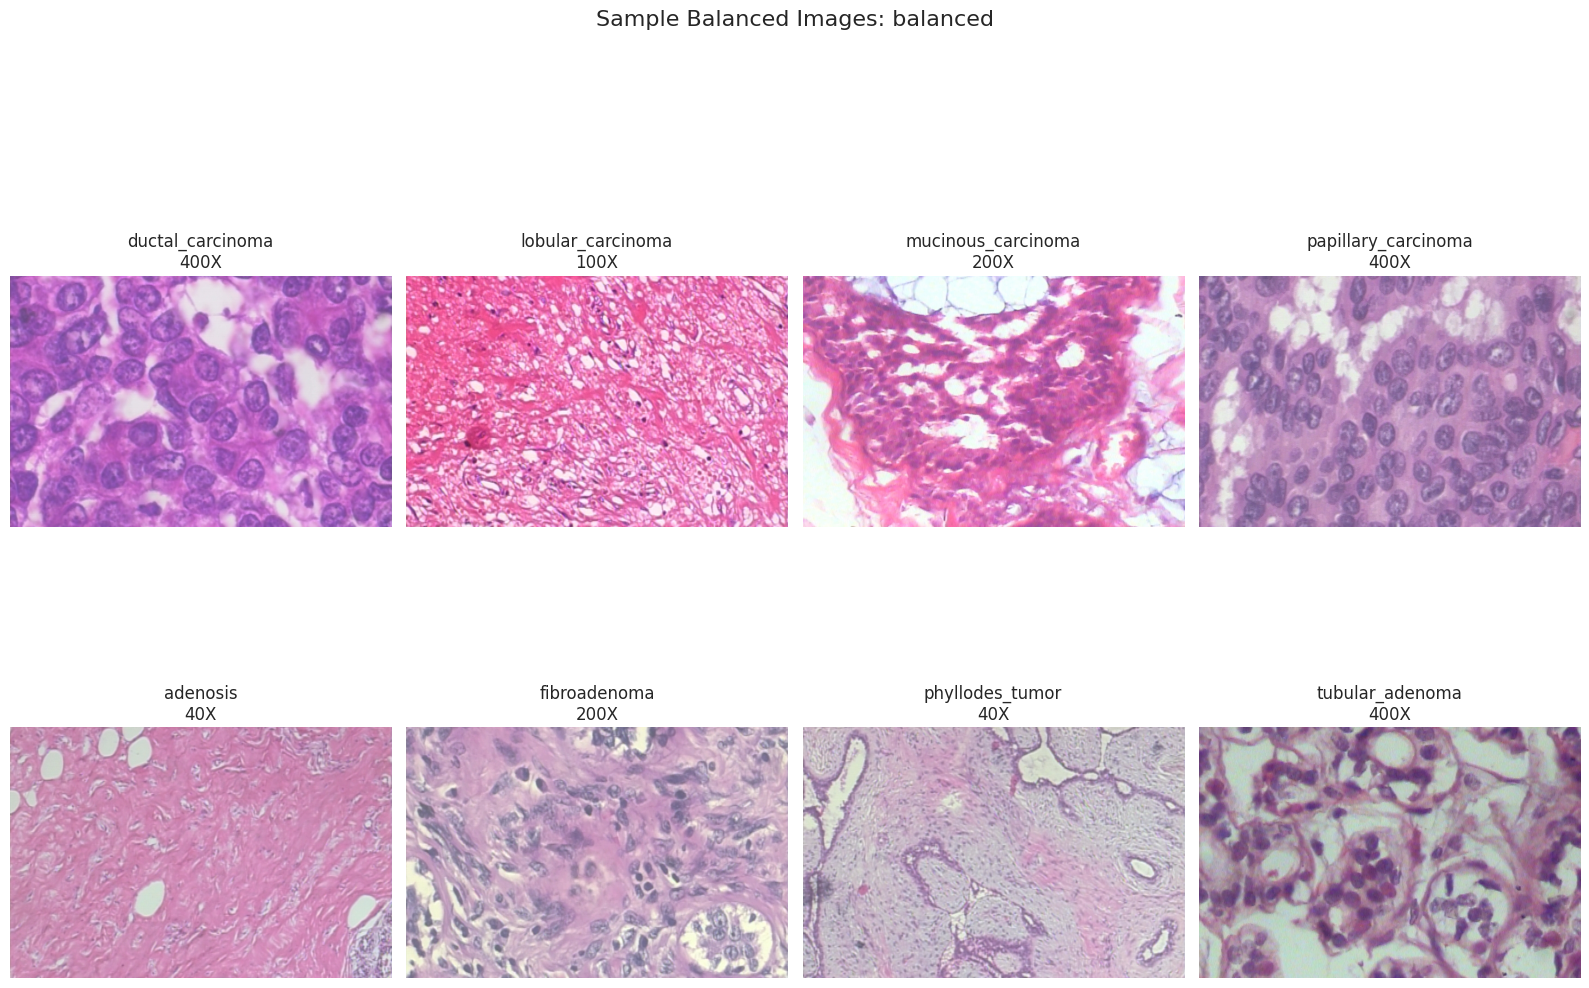

In [ ]:
# Function to plot one sample balanced image from each class and zoom level
def plot_sample_balanced_images(balanced_data, order=None):
    """
    Plots one sample image from the balanced dataset for each class and zoom level.

    Args:
        balanced_data (dict): Dataset organized by zoom level and class.
        order (list): List of class names defining the order of plotting.
    """
    zoom_levels_list = ['40X', '100X', '200X', '400X']

    for zoom_level, classes in balanced_data.items():
        # Convert the dictionary of lists into a DataFrame
        # Using Series handles potentially unequal list lengths
        df_classes = pd.DataFrame({k: pd.Series(v) for k, v in classes.items()})

        # Sample one image path from each class (column)
        # apply iterates over columns; dropna ensures we don't sample NaNs
        sampled_paths = df_classes.apply(lambda x: x.dropna().sample(1).iloc[0])

        # Reorder if order is provided
        if order:
             # Filter order to ensure we only use keys present in the data
             valid_order = [o for o in order if o in sampled_paths.index]
             sampled_paths = sampled_paths.reindex(valid_order)

        plt.figure(figsize=(16, 12))
        plt.suptitle(f"Sample Balanced Images: {zoom_level}", fontsize=16)

        # Iterate over the sampled series to plot
        for i, (class_name, img_path) in enumerate(sampled_paths.items()):
            img = cv2.imread(img_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Extract zoom level from path
                current_zoom = next((z for z in zoom_levels_list if z in img_path), '')

                plt.subplot(2, 4, i + 1)
                plt.imshow(img_rgb)
                plt.title(f"{class_name}\n{current_zoom}", fontsize=12)
                plt.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

_order = [
    'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma',
    'adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'
    ]
plot_sample_balanced_images(balanced_data, order=_order)

## Pixel Intensity and Contrast Enhancement

In [ ]:
# Obtain the frequency for per-pixel intensities of the images
def get_pixel_intensity_counts(image):
    """
    Computes the normalized histogram for an image.

    Args:
        image (str or np.ndarray): File path or loaded image array.

    Returns:
        np.ndarray: Flattened and normalized histogram.
    """
    if isinstance(image, str):
        image = cv2.imread(image)
        if image is None:
            raise ValueError(f"Could not load image: {image}")

    hist = np.concatenate([
        cv2.calcHist([image], [channel], None, [256], [0, 256]).flatten()
        for channel in range(3)
    ])
    return cv2.normalize(hist, hist).flatten()

# Apply contrast adjustment on the images
def enhance_contrast_rgb(image_path):
    """
    Enhances contrast of an image using CLAHE.

    Args:
        image_path (str): Path to the image.

    Returns:
        np.ndarray: Enhanced image.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    ca = clahe.apply(a)
    cb  = clahe.apply(b)
    lab = cv2.merge((cl , ca , cb))
    return cv2.cvtColor(lab , cv2.COLOR_LAB2BGR)

In [ ]:
# Initialize an empty list to store the histogram data records
histogram_data = []

# Iterate through each class_name and its corresponding list of image_paths in the balanced_data['balanced'] dictionary
for class_name, image_paths in balanced_data['balanced'].items():
    # Select the first image path. If the list is not empty, proceed with processing.
    if len(image_paths) > 0:
        image_path = image_paths[0]

        #--- Process Original Image ---
        try:
            # Compute the normalized pixel intensity histogram
            original_histogram = get_pixel_intensity_counts(image_path)

            # Smooth the histogram using savgol_filter
            original_smoothed = savgol_filter(original_histogram, 11, 2)

            # Iterate through the range 0 to 255
            for i in range(256):
                histogram_data.append({
                    'Intensity': i,
                    'Frequency': original_smoothed[i],
                    'Type': 'Original',
                    'Class': class_name
                })
        except Exception as e:
            print(f"Error processing original image for {class_name}: {e}")

        # --- Process CLAHE-enhanced Image ---
        try:
            # Generate the enhanced image
            clahe_image = enhance_contrast_rgb(image_path)

            # Compute the normalized histogram of this enhanced image
            clahe_histogram = get_pixel_intensity_counts(clahe_image)

            # Smooth this histogram
            clahe_smoothed = savgol_filter(clahe_histogram, 11, 2)

            # Append records to the data list for each intensity i (0-255)
            for i in range(256):
                histogram_data.append({
                    'Intensity': i,
                    'Frequency': clahe_smoothed[i],
                    'Type': 'CLAHE',
                    'Class': class_name
                })
        except Exception as e:
            print(f"Error processing CLAHE image for {class_name}: {e}")

# Create a Pandas DataFrame named df_histograms
df_histograms = pd.DataFrame(histogram_data)

# Display the first few rows of df_histograms to verify the structure
display(df_histograms.head())

Intensity  Frequency      Type     Class
0          0        0.0  Original  adenosis
1          1        0.0  Original  adenosis
2          2        0.0  Original  adenosis
3          3        0.0  Original  adenosis
4          4        0.0  Original  adenosis

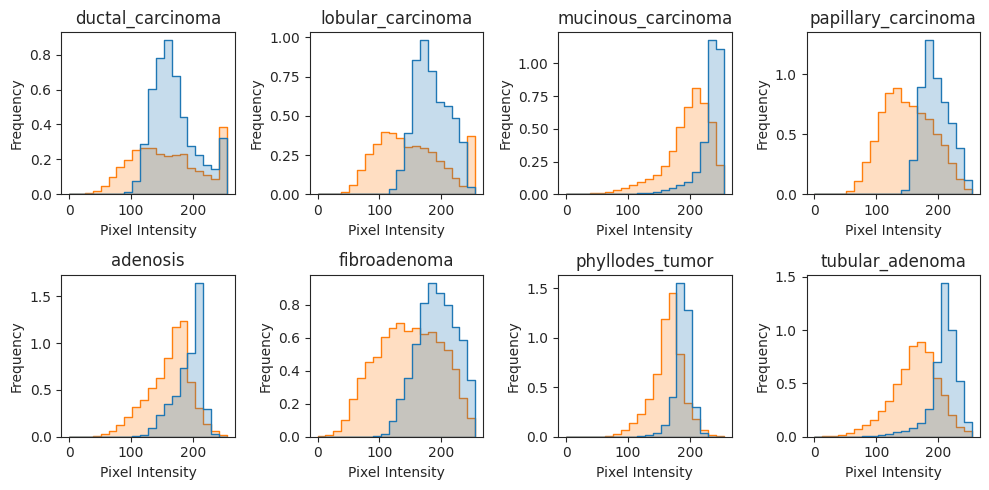

In [ ]:
# Define the desired order of classes
_order = [
    'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma',
    'adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'
    ]

# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()

# Iterate through the desired order and plot
for i, class_name in enumerate(_order):
    ax = axes[i]

    # Filter data for the current class
    class_data = df_histograms[df_histograms['Class'] == class_name]

    if not class_data.empty:
        # Plot using sns.histplot
        # We use 'weights' to represent the pre-calculated frequencies
        sns.histplot(
            data=class_data,
            x='Intensity',
            weights='Frequency',
            hue='Type',
            element='step',
            # fill=True,
            # multiple="stack",
            bins=20, #256,
            legend=False,
            # alpha=0.2,
            ax=ax
        )

        ax.set_title(class_name)
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
    else:
        ax.set_visible(False) # Hide axes if no data for this class


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

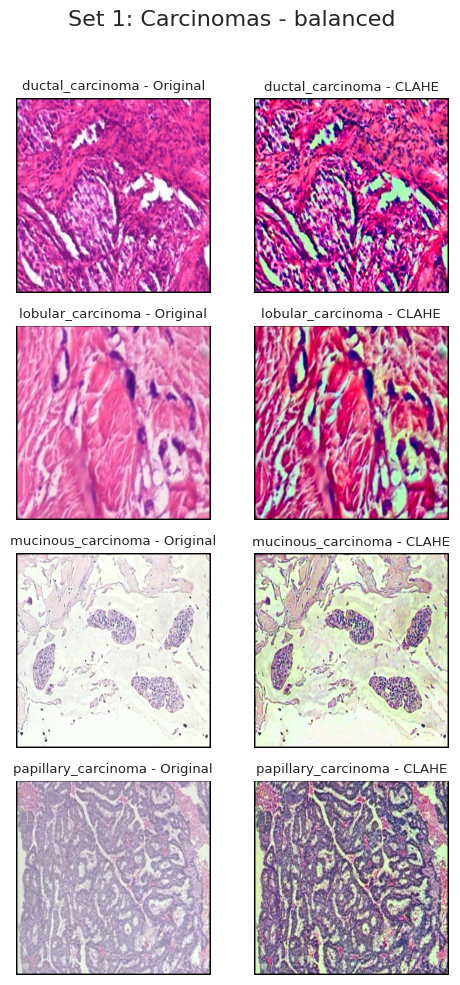

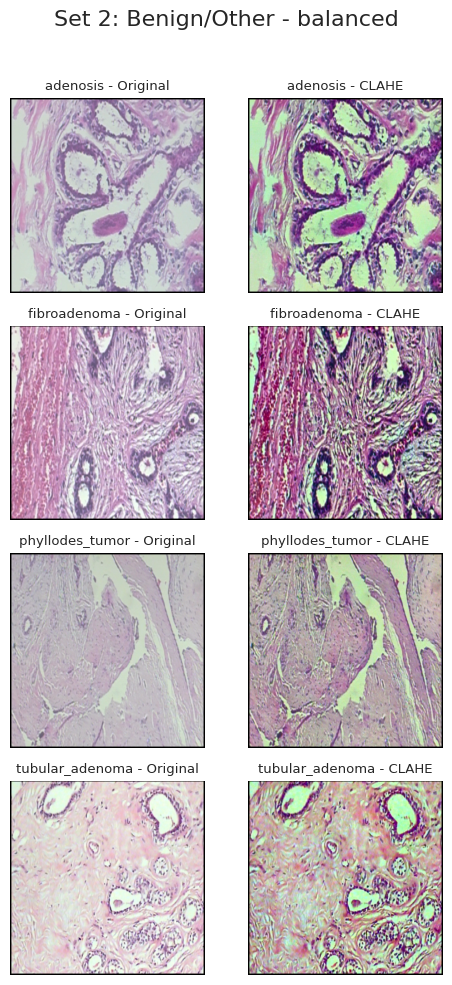

In [ ]:
# Function to plot comparison images
def plot_comparison_images(data):
    """
    Displays original and CLAHE-enhanced images for each class, separated into two sets.

    Args:
        data (dict): Dataset organized by zoom level and class.
    """
    # Define the two sets of classes
    set1 = ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
    set2 = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma']

    groups = [set1, set2]
    # Titles for the figures
    titles = ["Set 1: Carcinomas", "Set 2: Benign/Other"]

    for zoom_level, classes in data.items():

        # Iterate through each group to create a separate figure
        for group_idx, group_classes in enumerate(groups):
            num_rows = len(group_classes)
            # Create a figure with 4 rows and 2 columns
            # Increased height multiplier to ensure square subplots
            plt.figure(figsize=(5, 2.5 * num_rows))

            for i, class_name in enumerate(group_classes):
                image_paths = classes.get(class_name)
                if image_paths:
                    # Read and process images
                    original_image = cv2.imread(image_paths[0])
                    clahe_image = enhance_contrast_rgb(image_paths[0])

                    # Resize images to square dimensions for display
                    original_image = cv2.resize(original_image, (400, 400))
                    clahe_image = cv2.resize(clahe_image, (400, 400))

                    # Add border
                    border_size = 3
                    color = [0, 0, 0] # Black border
                    original_image = cv2.copyMakeBorder(original_image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=color)
                    clahe_image = cv2.copyMakeBorder(clahe_image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=color)

                    # Plot Original Image (Left Column)
                    plt.subplot(num_rows, 2, 2 * i + 1)
                    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                    plt.title(f"{class_name} - Original", fontsize=9.5)
                    plt.axis('off')

                    # Plot CLAHE Image (Right Column)
                    plt.subplot(num_rows, 2, 2 * i + 2)
                    plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))
                    plt.title(f"{class_name} - CLAHE", fontsize=9.5)
                    plt.axis('off')

            plt.suptitle(f"{titles[group_idx]} - {zoom_level}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

# Plot comparison images and histograms
plot_comparison_images({'balanced': balanced_data['balanced']})

In [ ]:
# CLAHE for Color Images
def clahe_transformer(image):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to a color image.

    The image is converted to LAB color space, CLAHE is applied to each channel,
    then it is converted back to BGR.

    Args:
        image: Input color image in BGR format (NumPy array).

    Returns:
        NumPy array: CLAHE-enhanced color image in BGR format.
    """
    # Convert from BGR to LAB color space (L*: lightness, a*/b*: color)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split LAB image into separate channels
    l, a, b = cv2.split(lab)

    # Create CLAHE object (tile grid of 8x8, clip limit 2.0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Apply CLAHE to each LAB channel
    cl = clahe.apply(l)
    ca = clahe.apply(a)
    cb = clahe.apply(b)

    # Merge enhanced channels and convert back to BGR
    lab = cv2.merge((cl, ca, cb))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


# Preprocessing
def preprocess_image(image_path, target_size, augment=False, apply_clahe=False):
    """
    Load and preprocess a single image from disk.

    Steps:
    - Read the image from disk.
    - Optionally apply CLAHE.
    - Resize to target_size.
    - Normalize to [0, 1].
    - Optionally apply simple data augmentation.

    Args:
        image_path: Path to the image (bytes/str, as passed from tf.numpy_function).
        target_size: Tuple (width, height) to resize the image to.
        augment: Whether to apply random flips.
        apply_clahe: Whether to apply CLAHE to the image.

    Returns:
        Preprocessed image as a float32 NumPy array with values in [0, 1].
    """
    image = cv2.imread(image_path.decode("utf-8"))

    if apply_clahe:
        image = clahe_transformer(image)

    image = cv2.resize(image, target_size)
    image = image.astype("float32") / 255.0

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)

    return image


# Preprocessing Wrapper
def preprocess_image_wrapper(image_path, label, target_size, augment, apply_clahe):
    """
    TensorFlow wrapper around preprocess_image for use with tf.data.

    Args:
        image_path: Tensor containing the image path.
        label: One-hot encoded label tensor.
        target_size: Tuple (width, height).
        augment: Whether to apply data augmentation.
        apply_clahe: Whether to apply CLAHE.

    Returns:
        (image, label) pair where image is a float32 tensor of shape
        (target_size[0], target_size[1], 3).
    """
    def _preprocess(path):
        return preprocess_image(path, target_size, augment, apply_clahe)

    image = tf.numpy_function(_preprocess, inp=[image_path], Tout=tf.float32)
    image.set_shape((*target_size, 3))

    return image, label


# Create Dataset
def create_dataset(image_paths, labels, batch_size=32, target_size=(224, 224),
                   augment=False, apply_clahe=False):
    """
    Build a tf.data.Dataset pipeline from image paths and integer labels.

    Args:
        image_paths: List/array of image paths.
        labels: List/array of integer class labels.
        batch_size: Batch size for the dataset.
        target_size: Resize size (width, height).
        augment: Whether to apply data augmentation.
        apply_clahe: Whether to apply CLAHE.

    Returns:
        tf.data.Dataset yielding (image, one-hot-label) batches.
    """
    labels = to_categorical(labels, num_classes=len(set(labels)))

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(
        lambda x, y: preprocess_image_wrapper(x, y, target_size, augment, apply_clahe),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


# Main - Load Dataset
data, all_images, all_labels, label_map = read_in_data(malignant_path, benign_path)

# Balance Dataset
balanced_paths, balanced_labels = balance_dataset(all_images, all_labels)

# Split Data using sklearn (Training 70%, Validation 15%, Testing 15%)
# 70% Train, the remaining 30% is set aside for Validation and Testing
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    balanced_paths,
    balanced_labels,
    test_size=0.3,
    random_state=42,
    stratify=balanced_labels,
)

# Split the the 30% set (temp_paths, temp_labels) into 50% for Validation and 50% for Testing
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels,
)

# Create Datasets
train_dataset = create_dataset(train_paths, train_labels, augment=True, apply_clahe=True)
val_dataset   = create_dataset(val_paths, val_labels, apply_clahe=True)
test_dataset  = create_dataset(test_paths, test_labels, apply_clahe=True)


## Attention-Based Model Architecture (CBAM)

In [ ]:
# CBAM Layer
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Conv2D, Concatenate, Activation, Add
import tensorflow as tf

class CBAM(Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_dense_one = Dense(channel // self.reduction_ratio,
                                      activation='relu',
                                      kernel_initializer='he_normal',
                                      use_bias=True,
                                      bias_initializer='zeros')
        self.shared_dense_two = Dense(channel,
                                      kernel_initializer='he_normal',
                                      use_bias=True,
                                      bias_initializer='zeros')
        self.conv2d = Conv2D(filters=1,
                             kernel_size=7,
                             strides=1,
                             padding='same',
                             activation='sigmoid',
                             kernel_initializer='he_normal',
                             use_bias=False)
        super(CBAM, self).build(input_shape)

    def call(self, input_feature):
        # Channel Attention Module
        avg_pool = GlobalAveragePooling2D()(input_feature)
        avg_pool = Reshape((1, 1, input_feature.shape[-1]))(avg_pool)
        avg_pool = self.shared_dense_one(avg_pool)
        avg_pool = self.shared_dense_two(avg_pool)

        max_pool = GlobalMaxPooling2D()(input_feature)
        max_pool = Reshape((1, 1, input_feature.shape[-1]))(max_pool)
        max_pool = self.shared_dense_one(max_pool)
        max_pool = self.shared_dense_two(max_pool)

        channel_attention = Activation('sigmoid')(Add()([avg_pool, max_pool]))
        channel_refined = Multiply()([input_feature, channel_attention])

        # Spatial Attention Module
        avg_pool = tf.reduce_mean(channel_refined, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(channel_refined, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.conv2d(concat)
        refined_feature = Multiply()([channel_refined, spatial_attention])

        return refined_feature


def build_model_with_cbam(input_shape=(224, 224, 3), num_classes=8):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = CBAM()(x)
    x = Flatten()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

## Training, Validation, and Test Evaluation

## Training Curves, Classification Report, and ROC Analysis

In [ ]:
model_with_cbam = build_model_with_cbam()
model_with_cbam.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

history = model_with_cbam.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the entire model (architecture + weights + optimizer state)
model_with_cbam.save('./training_model.keras')
# Save the history.history dictionary to a file
with open('./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/code/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 744s 3s/step - accuracy: 0.1324 - loss: 2.6358 - precision: 0.1305 - recall: 0.0293 - val_accuracy: 0.1821 - val_loss: 2.0681 - val_precision: 0.0625 - val_recall: 8.4317e-04 - learning_rate: 0.0010
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 52s 297ms/step - accuracy: 0.2021 - loss: 2.1804 - precision: 0.2546 - recall: 0.0354 - val_accuracy: 0.1981 - val_loss: 2.1283 - val_precision: 0.6875 - val_recall: 0.0093 - learning_rate: 0.0010
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.3484 - loss: 1.7141 - precision: 0.4751 - recall: 0.1179 - val_accuracy: 0.3845 - val_loss: 2.5327 - val_precision: 0.4333 - val_recall: 0.1998 - learning_rate: 0.0010
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 52s 299ms/step - accuracy: 0.4800 - loss: 1.4092 - precision: 0.6138 - recall: 0.2576 - val_accuracy: 0.5632 - val_loss: 1.1680 - val_precision: 0.7301 - val_recall: 0.3626 - learning_rate: 0.0

In [ ]:
## Load Google drive to open the pickle file
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
hp = pickle.load(open('./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/code/training_history.pkl', 'rb'))
hp['accuracy']

[0.14370933175086975,
 0.2357194572687149,
 0.3830440938472748,
 0.4963846802711487,
 0.5786334276199341,
 0.6287057399749756,
 0.6807664632797241,
 0.6999276876449585,
 0.7180043458938599,
 0.7492769360542297,
 0.7716919779777527,
 0.7863340377807617,
 0.8031453490257263,
 0.8694866299629211,
 0.8971439003944397,
 0.8967823386192322,
 0.9072667956352234,
 0.9291395545005798,
 0.9436008930206299,
 0.9399855136871338,
 0.9528199434280396,
 0.9654735922813416,
 0.9652928709983826,
 0.9708966016769409,
 0.9730657935142517,
 0.9708966016769409,
 0.9797541499137878,
 0.9857194423675537,
 0.9793926477432251,
 0.989154040813446,
 0.9920462965965271,
 0.9924077987670898,
 0.9969269633293152]

In [ ]:
from tensorflow.keras.models import load_model

# Assuming your model is saved as 'my_model.keras' in the current directory
# Pass the custom layer class 'CBAM' so Keras knows how to deserialize it
x_model = load_model('./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/code/training_model.keras', custom_objects={'CBAM': CBAM})

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 509 variables whereas the saved optimizer has 1016 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
x_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_1 (CBAM)                   │ (None, 5, 5, 1536)     │       296,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    19,661,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_204         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_205         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,864,726 (567.87 MB)

 Trainable params: 74,401,194 (283.82 MB)

 Non-trainable params: 62,336 (243.50 KB)

 Optimizer params: 74,401,196 (283.82 MB)

In [ ]:
x_model.evaluate(test_dataset)

38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9599 - loss: 0.1655 - precision: 0.9615 - recall: 0.9556


[0.18153069913387299,
 0.9553119540214539,
 0.9584393501281738,
 0.9527824521064758]

In [ ]:
# Evaluate the model on the test dataset
results = x_model.evaluate(test_dataset)

# results[0] is loss, results[1] is accuracy
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9599 - loss: 0.1655 - precision: 0.9615 - recall: 0.9556
Test Loss: 0.1815
Test Accuracy: 95.53%


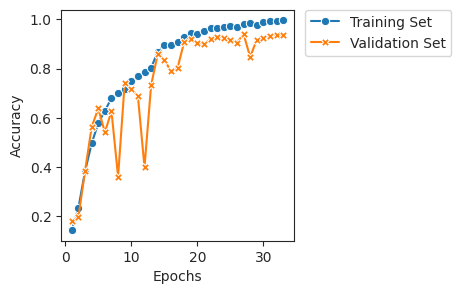

In [ ]:
sns.set_style("ticks")
# Extract values from the history object
df_eval_acc = pd.DataFrame({
    "Training Set"    : history.history['accuracy'],
    "Validation Set"  : history.history['val_accuracy'],
    "epochs"          : range(1, len(history.history['accuracy']) + 1)
}).melt(id_vars='epochs')

df_eval_loss = pd.DataFrame({
    "Training Set"   : history.history['loss'],
    "Validation Set" : history.history['val_loss'],
    "epochs"          : range(1, len(history.history['accuracy']) + 1)
}).melt(id_vars='epochs')

# Plot the lineplot
plt.figure(figsize=(3, 3))
# Plot the lineplot
ax = sns.lineplot(data=df_eval_acc, x='epochs', y='value', hue='variable', style='variable', markers=True, dashes=False)

# 1. Rename axes
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

# 2. & 3. Make the figure legend outside the plot and omit legend title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=None)
# plt.tight_layout()
plt.show()

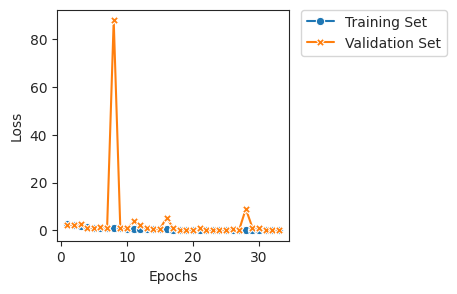

In [ ]:
# Plot the lineplot
plt.figure(figsize=(3, 3))
# Plot the lineplot
ax = sns.lineplot(data=df_eval_loss, x='epochs', y='value', hue='variable', style='variable', markers=True, dashes=False)

# 1. Rename axes
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

# 2. & 3. Make the figure legend outside the plot and omit legend title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=None)
# plt.tight_layout()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step


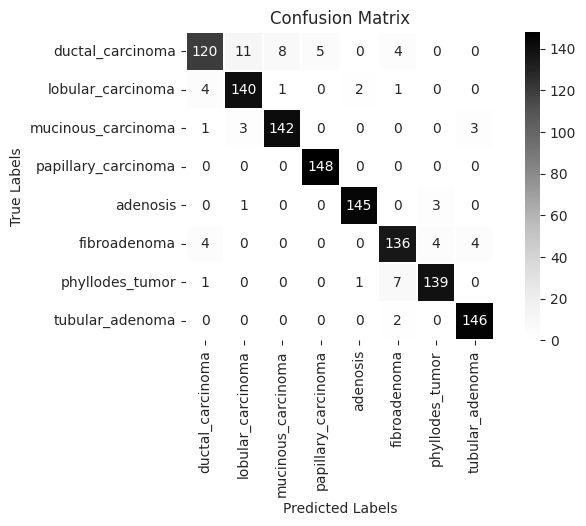

In [ ]:
# Make predictions
y_pred = model_with_cbam.predict(test_dataset)
y_true = test_labels

# Convert y_true to a NumPy array
y_true = np.array(y_true)

# If y_true is one-hot encoded, convert it to class labels
y_true = y_true.argmax(axis=1) if y_true.ndim > 1 else y_true

# Get the predicted class labels from the softmax probabilities
y_pred = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
label_map.keys()

# Plot confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True,
            fmt='d',
            cmap='Grays',
            linewidth=.3,
            linecolor='white',
            square=True,
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Generate the classification report
report = classification_report(y_true, y_pred, target_names=label_map.keys())
print(report)

                     precision    recall  f1-score   support

   ductal_carcinoma       0.92      0.81      0.86       148
  lobular_carcinoma       0.90      0.95      0.92       148
 mucinous_carcinoma       0.94      0.95      0.95       149
papillary_carcinoma       0.97      1.00      0.98       148
           adenosis       0.98      0.97      0.98       149
       fibroadenoma       0.91      0.92      0.91       148
    phyllodes_tumor       0.95      0.94      0.95       148
    tubular_adenoma       0.95      0.99      0.97       148

           accuracy                           0.94      1186
          macro avg       0.94      0.94      0.94      1186
       weighted avg       0.94      0.94      0.94      1186



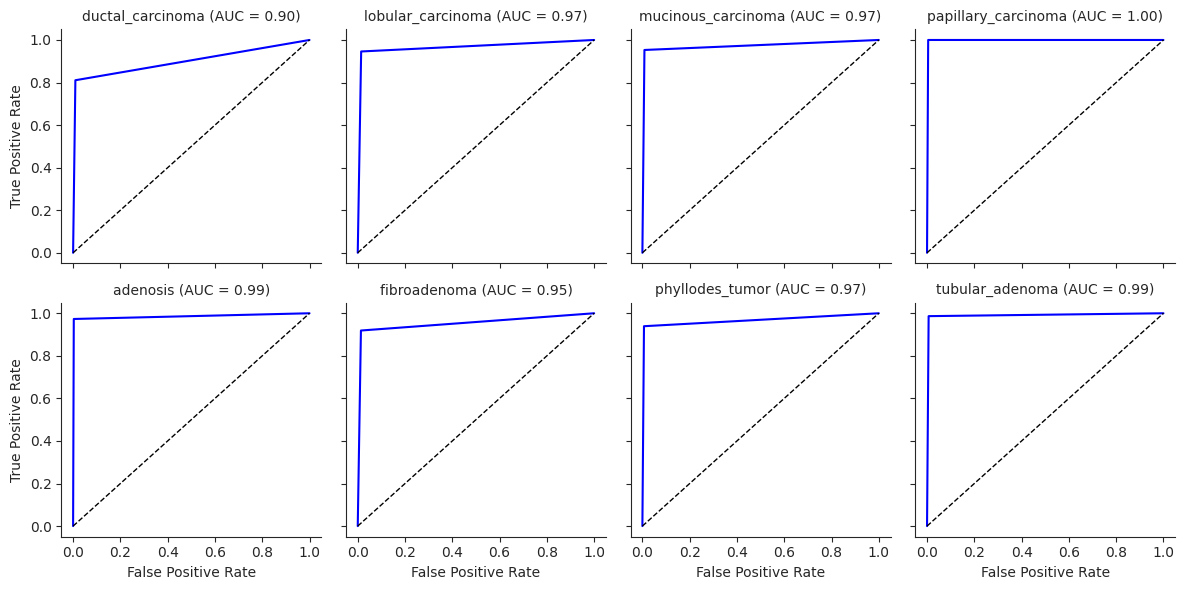

In [ ]:
y_true_bin = label_binarize(y_true, classes=[i for i in range(len(label_map))])
y_pred_bin = label_binarize(y_pred, classes=[i for i in range(len(label_map))])

roc_data = []

for i in range(len(label_map)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    class_name = list(label_map.keys())[i]
    # Append data for this class to the list
    roc_data.append(pd.DataFrame({
        'False Positive Rate': fpr,
        'True Positive Rate': tpr,
        'Class': f'{class_name} (AUC = {roc_auc:.2f})'
    }))

df_roc = pd.concat(roc_data, ignore_index=True)

# Plot using FacetGrid
g = sns.FacetGrid(df_roc, col="Class", col_wrap=4, height=3, sharex=True, sharey=True)
g.map(sns.lineplot, "False Positive Rate", "True Positive Rate", color='blue')

for ax in g.axes.flatten():
    ax.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)

# Adjust titles and layout
g.set_titles("{col_name}")
plt.show()